## Importing the Libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk # natural-language-toolkit

from sklearn.model_selection import train_test_split,GridSearchCV # for machine learning
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc # machine learning metrics
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)

## Importing the dataset

In [101]:
data = pd.read_csv("sentiment.tsv",sep = "\t")
data.columns = ['label','body_text']
data.head()

,label,body_text
0,pos,having a vodka tonic and looking forward to go...
1,pos,@ddlovatofans1neg1 Could you follow me please....
2,pos,@jordanknight for once.................. PLEAS...
3,neg,Had a dream about a walk in fast food resturau...
4,pos,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [102]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label']) # encode "pos"/"neg" label to 1/0
data.head()

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


## Cleaning of Data

In [103]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt) # returns list where it finds pattern occurring.
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

## Remove twitter handles (@user)

In [104]:
# Remove any twitter handles in tweets.
# pass remove_pattern into np.vectorize creates a new "function"
# new function takes in iterables of input_txt, and a single pattern
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['body_text'],"@[\w]*")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


## Remove special characters, numbers, punctuations

In [105]:
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes For a quot friend quot


## Tokenize and Stemming the tweets

From [MachineLearningMastery](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/):

> Text data requires special preparation before you can start using it for predictive modeling.
> 
> The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

The words _have_ and _having, look_ and _looking,_ should be treated similarly. Hence, to take care of this, we use a method called _stemming_.

In [106]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

In [107]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

## Joining the tokenized word in the same data

In [108]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
data['tidy_tweet'] = tokenized_tweet
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot


## Adding other column for length of the tweet and punctuation

In [109]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*100

In [110]:
data['body_len'] = data['body_text'].apply(lambda x:len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x:count_punct(x))
data.head()

,label,body_text,tidy_tweet,body_len,punct%
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot,44,18.2


## Generating word cloud for corpus of words

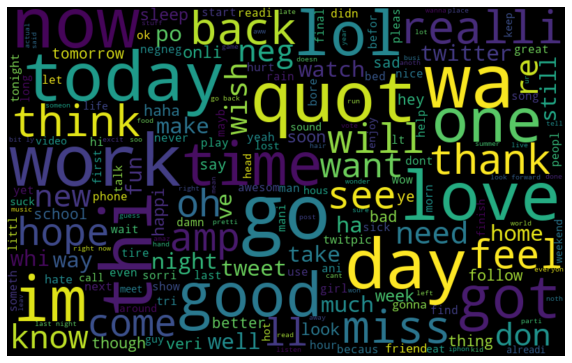

In [111]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in data['tidy_tweet']])
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for negative tweets

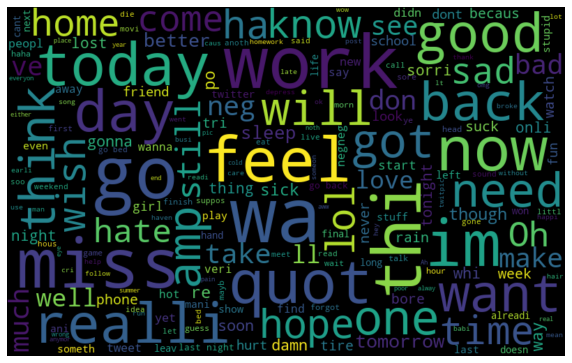

In [112]:
negative_words = ' '.join([text for text in data['tidy_tweet'][data['label']==0]])
wordcloud = WordCloud(width=800, height = 500, random_state=27,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [113]:
# function to collect hashtags
def hashtag_extract(x):
    hashtag = []
    # loop over the words
    for i in x:
        ht = re.findall(r"#(\w+)",i)
        hashtag.append(ht)
    return hashtag

In [114]:
# extract hash from no racist/sexist tweets
HT_regular = hashtag_extract(data['tidy_tweet'][data['label']==0])
# positive
HT_negative = hashtag_extract(data['tidy_tweet'][data['label']==1])
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [115]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d.head()

,Hashtag,count
0,github,1
1,fb,2
2,stupidgalaev,1
3,nswdet,1
4,bgt,1


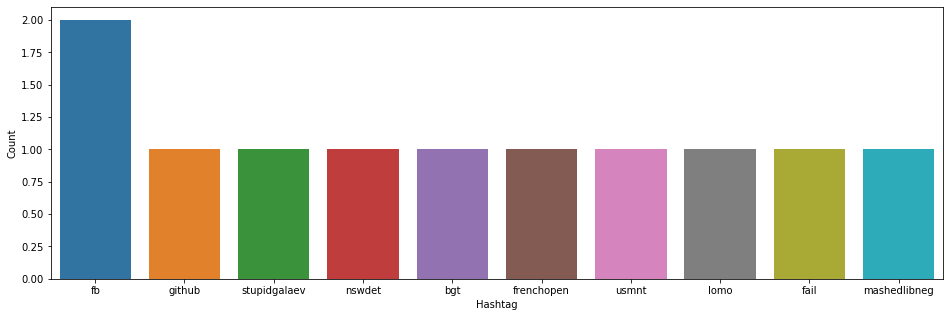

In [116]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

## Histogram for Negative tweets

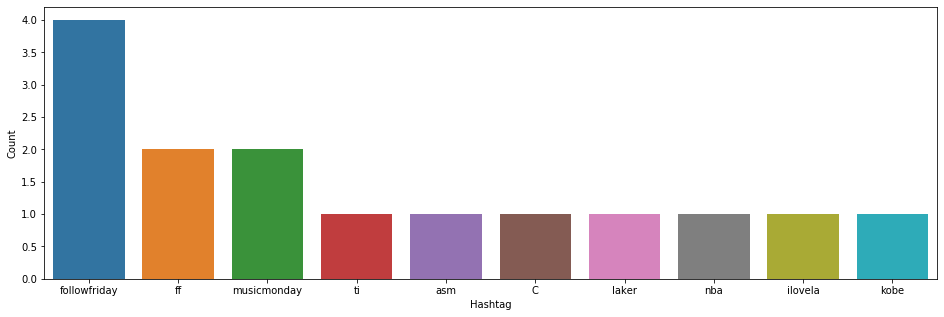

In [117]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

## Feature selection and Engineering

From [MachineLearningMastery](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/):

**Bag-of-Words Model**
> We cannot work with text directly when using machine learning algorithms.
>
> Instead, we need to convert the text to numbers.
>
> We may want to perform classification of documents, so each document is an “input” and a class label is the “output” for our predictive algorithm. Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.
>
> A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.
The model is simple in that it throws away all of the order information in the words and focuses on the occurrence of words in a document.
>
> This can be done by assigning each word a unique number. Then any document we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document.
>
> This is the bag of words model, where we are only concerned with encoding schemes that represent what words are present or the degree to which they are present in encoded documents without any information about order.
There are many ways to extend this simple method, both by better clarifying what a “word” is and in defining what to encode about each word in the vector.

There are many different vectorizers that we can use. We will look at two:
1. Count Vectorizer - counts occurrence
2. TF-IDF Vectoriser - normalize frequency of word in corpus

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# bag-of-words
bow_vectorizer = CountVectorizer(stop_words='english')
bow = bow_vectorizer.fit_transform(data['tidy_tweet'])
X_count_feat = pd.concat([data['body_len'],data['punct%'],pd.DataFrame(bow.toarray())],axis = 1)
X_count_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet'])
X_tfidf_feat = pd.concat([data['body_len'],data['punct%'],pd.DataFrame(tfidf.toarray())],axis = 1)
X_tfidf_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81,27.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44,18.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Testing all classification algorithms

In [28]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [29]:
model = []
model.append(('LR',LogisticRegression()))
model.append(('RF',RandomForestClassifier()))
model.append(('GB',GradientBoostingClassifier()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('NB',GaussianNB()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('SVC',SVC()))

## 10 fold crossvalidation for all the algorithms with X_count_feat data

In [30]:
for mod,clf in model:
    scores = cross_val_score(clf,X_count_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Model is LR and Score 0.669000
Model is RF and Score 0.673500
Model is GB and Score 0.649000
Model is DT and Score 0.602000
Model is NB and Score 0.598500
Model is KNN and Score 0.502000
Model is SVC and Score 0.491500


## 10 fold crossvalidation for all the algorithms with X_tfidf_feat data

In [31]:
for mod,clf in model:
    scores = cross_val_score(clf,X_tfidf_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Model is LR and Score 0.679000
Model is RF and Score 0.655000
Model is GB and Score 0.631500
Model is DT and Score 0.574000
Model is NB and Score 0.598000
Model is KNN and Score 0.486500
Model is SVC and Score 0.491000


## 1) Parameter tuning Linear Regression Count Vectorizer

In [40]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_count_feat,data['label'])

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
Logistic_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_count_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Model is LR and Score 0.689500


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2) Parameter tuning Linear Regression TfiDf

In [49]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_tfidf_feat,data['label'])

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
Logistic_model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_tfidf_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Model is LR and Score 0.679000


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data['label'], test_size=0.33, random_state=42)

In [55]:
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
pred = model.predict(X_test)

In [57]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [58]:
accuracy_score(pred,y_test)

0.6772727272727272

In [59]:
#                    Actual Class 1 | Actual Class 2
# Predict Class 1 |       
# Predict Class 2 |
confusion_matrix(y_test,pred)

array([[217,  96],
       [117, 230]], dtype=int64)

# Creating Function for Processing Data

In [180]:
def process_text(input_txt):
    # if input is string
    tidy_txt = remove_pattern(input_txt,"@[\w]*")
    ##=============================== if input is dataframe ====================##
    # tidy_txt = np.vectorize(remove_pattern)(input_txt,"@[\w]*")                #
    ##==========================================================================##
    # remove special characters
    tidy_txt = tidy_txt.replace("[^a-zA-Z#]"," ")
    # split into words
    tokenized_txt = tidy_txt.split()
    # perform stemming
    stemmer = PorterStemmer()
    tokenized_txt = [stemmer.stem(i) for i in tokenized_txt]
    print(tokenized_txt)
    # joining words back
    tokenized_txt = ' '.join(tokenized_txt)
    return tokenized_txt

In [181]:
message1 = "having a vodka tonic and looking forward"
message2 = "have a vodka tonic and look forward "
m1 = [process_text(message1),]
m2 = [process_text(message2),]
vect1 = pd.DataFrame(bow_vectorizer.transform(m1).toarray())
vect2 = pd.DataFrame(bow_vectorizer.transform(m2).toarray())

['have', 'a', 'vodka', 'tonic', 'and', 'look', 'forward']
['have', 'a', 'vodka', 'tonic', 'and', 'look', 'forward']


In [143]:
rows, cols = np.where(vect1 == 1)
print(rows)
print(cols)

[0 0 0]
[1289 3490 3681]


In [144]:
rows, cols = np.where(vect2 == 1)
print(rows)
print(cols)

[0 0 0 0]
[1289 2018 3490 3681]


In [126]:
vect1

,0,1,2,3,4,5,6,7,8,9,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:

print(match_df.where(match_df == False).dropna().index)
print(match_df.where(match_df == False).dropna().columns)

Int64Index([], dtype='int64')
RangeIndex(start=0, stop=3944, step=1)


In [74]:

body_len = pd.DataFrame([len(data1) - data1.count(" ")])
punct = pd.DataFrame([count_punct(data1)])
total_data1 = pd.concat([body_len,punct,vect1],axis = 1)
my_prediction = model.predict(total_data1)
my_prediction[0]

0

In [121]:
data

,label,body_text,tidy_tweet,body_len,punct%
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot,44,18.2
...,...,...,...,...,...
1995,0,STILL @ panera...studying for &quot;mock&quot;...,still panera studi for quot mock quot board ex...,70,15.7
1996,0,Insomnia is out of control tonight--haven't sl...,insomnia is out of control tonight haven t sle...,49,8.2
1997,1,@Covergirlneg8 I take pride in what I do,I take pride in what I do,33,3.0
1998,1,heading to work on the 6,head to work on the,19,0.0


,0,1,2,3,4,5,6,7,8,9,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943


In [76]:
body_len = pd.DataFrame([len(data2) - data2.count(" ")])
punct = pd.DataFrame([count_punct(data2)])
total_data2 = pd.concat([body_len,punct,vect2],axis = 1)
my_prediction = model.predict(total_data2)
my_prediction[0]

0